# Trabalho 2

Análise de Dados Espaciais - MapBiomas Uso e Cobertura do Solo

In [263]:
#Bibliotecas necessárias
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


In [275]:
#Determinando os caminhos
#Arquivo uso do solo
usosolo=r'../dados_solo/brasil_coverage_2013.tif'
#Extraindo o ano do uso do solo do arquivo
ano = usosolo.split('_')[-1].split('.')[0]
#Arquivo com shape do local de interesse
shape=r'../dados_solo/bacia_ratones.shp'
print(ano)

2013


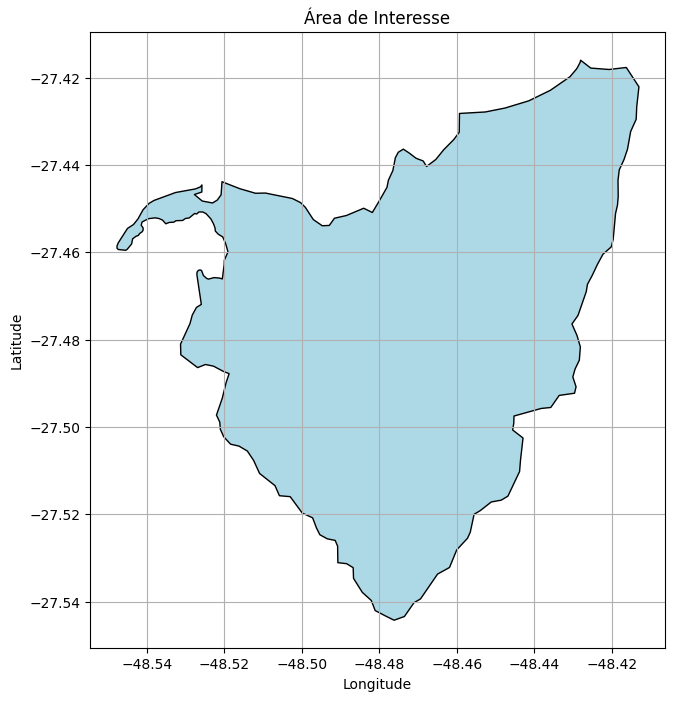

In [276]:
#Lendo shape com Geopandas
vector=gpd.read_file(shape)
#Reprojetando para a figura sair em sigas2000
# Reprojetar para o CRS desejado
vector_reprojected = vector.to_crs(epsg=4674)

# Plotar o shapefile reprojetado
fig, ax = plt.subplots(figsize=(10, 8))
vector_reprojected.plot(ax=ax, color='lightblue', edgecolor='black')

# Configurar os rótulos dos eixos
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Área de Interesse")
plt.grid(True)
plt.show()

In [277]:
# Garantir que o shapefile e o raster tenham o mesmo sistema de referência
with rasterio.open(usosolo) as src:
    if vector.crs != src.crs:
        vector = vector.to_crs(src.crs)
# Converter os polígonos do shapefile em um formato utilizável pelo Rasterio
geometries = [feature["geometry"] for feature in vector.__geo_interface__["features"]]

In [278]:
# Abrir o raster e aplicar o recorte
with rasterio.open(usosolo) as src:
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()

In [279]:
# Atualizar os metadados do raster recortado
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

In [280]:
# Salvar o raster recortado
rasterclip = r'../dados_solo/recortado_brasil_coverage_'+ano+'.tif'
with rasterio.open(rasterclip, "w", **out_meta) as dest:
    dest.write(out_image)

In [281]:
#Identificando os valores únicos de um raster
# Abrir o raster
with rasterio.open(rasterclip) as src:
    # Ler a primeira banda do raster
    raster_data = src.read(1)  # Supondo um raster de banda única

    # Obter os valores únicos e suas frequências
    unique_values, counts = np.unique(band, return_counts=True)  # Adicione return_counts=True
    
    # Criar um dicionário com o valor único e sua frequência
    frequency_dict = dict(zip(unique_values, counts))
    
    # Exibir a frequência de cada valor único
    for value, count in frequency_dict.items():
        print(f"Classe: {value}, Frequência: {count}")

Classe: 0, Frequência: 124984
Classe: 3, Frequência: 34790
Classe: 5, Frequência: 7253
Classe: 9, Frequência: 5631
Classe: 15, Frequência: 6487
Classe: 21, Frequência: 26048
Classe: 24, Frequência: 11986
Classe: 25, Frequência: 152
Classe: 29, Frequência: 50
Classe: 32, Frequência: 1169
Classe: 33, Frequência: 1304
Classe: 41, Frequência: 5
Classe: 49, Frequência: 19118


In [282]:
#Lendo a legenda de uso do solo do MapBiomas
csv_path = r'../dados_solo/Codigos-da-legenda-colecao-9.csv'
# Ler o arquivo CSV
#Atenção, foi necessário corrigir o arquivo para entrada, removendo as virgulas nas linhas 31 e 35
df = pd.read_csv(csv_path, sep=';')
print(df.head())

#Transformando a minha legenda em um dicionário
legenda = dict(zip(df['Class_ID'], df['Description']))

   Class_ID  Level        Description           Descricao    Color
0         1      1             Forest            Floresta  #32a65e
1         3      2   Forest Formation  Formação Florestal  #1f8d49
2         4      2  Savanna Formation   Formação Savânica  #7dc975
3         5      2           Mangrove              Mangue  #04381d
4         6      2   Floodable Forest   Floresta Alagável  #026975


In [283]:
# Associar os valores únicos às descrições no dicionário
associated_values = {value: class_dict.get(value, "Sem descrição") for value in unique_values}

# Exibir o resultado
print("Associações:")
for value, description in associated_values.items():
    print(f"{value}: {description}")

Associações:
0: Sem descrição
3: Forest Formation
5: Mangrove
9:  Forest Plantation
15:  Pasture
21:  Mosaic of Uses
24:  Urban Area
25:  Other non Vegetated Areas
29:  Rocky Outcrop
32:  Hypersaline Tidal Flat
33:  River and Lake and Ocean
41:  Other Temporary Crops
49: Wooded Sandbank Vegetation


In [300]:
#Definindo cores
# Carregar o CSV
color_mapping = pd.read_csv(csv_path, sep=';')
# Garantir que as cores estão no formato correto
color_mapping['Color'] = color_mapping['Color'].apply(lambda x: x.strip())  # Remover espaços em branco
color_mapping


,Class_ID,Level,Description,Descricao,Color
0,1,1,Forest,Floresta,#32a65e
1,3,2,Forest Formation,Formação Florestal,#1f8d49
2,4,2,Savanna Formation,Formação Savânica,#7dc975
3,5,2,Mangrove,Mangue,#04381d
4,6,2,Floodable Forest,Floresta Alagável,#026975
5,49,2,Wooded Sandbank Vegetation,Restinga Arbórea,#02d659
6,10,1,Herbaceous and Shrubby Vegetation,Vegetação Herbácea e Arbustiva,#ad975a
7,11,2,Wetland,Campo Alagado e Área Pantanosa,#519799
8,12,2,Grassland,Formação Campestre,#d6bc74
9,32,2,Hypersaline Tidal Flat,Apicum,#fc8114


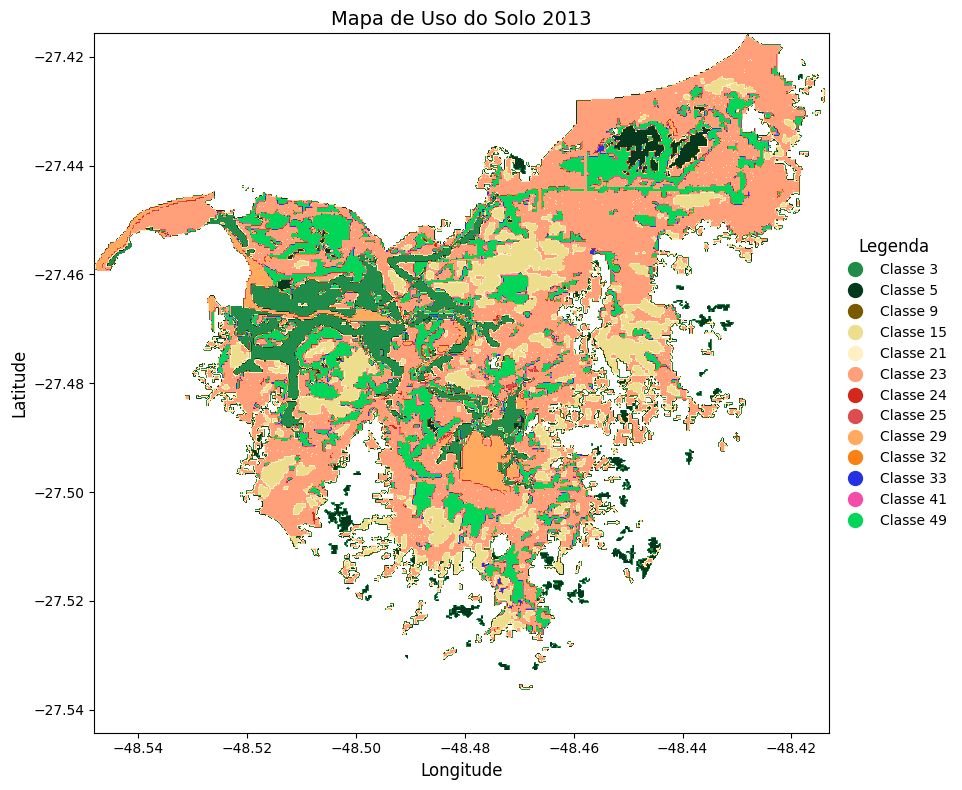

In [310]:
#Abrindo e plotando raster recortado para a área de interesse
dataset=rasterio.open(rasterclip)

# Obter os valores únicos do raster
unique_values = np.unique(raster_data)

# Criar um dicionário de cores para os valores únicos
color_dict = dict(zip(color_mapping['Class_ID'], color_mapping['Color']))

# Criar uma lista de cores, definindo 'white' para valores sem correspondência
colors = [color_dict.get(value, 'white') for value in unique_values]
cmap = ListedColormap(colors)

# Obter a transformação espacial para o raster
transform = dataset.transform
# Obter os limites do raster (coordenadas em sistema de referência espacial)
x_min, y_max = transform * (0, 0)  # Coordenada do canto superior esquerdo
x_max, y_min = transform * (dataset.width, dataset.height)  # Coordenada do canto inferior direito

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Plotar a imagem com a transformação
img = ax.imshow(raster_data, cmap=cmap, extent=(x_min, x_max, y_min, y_max))

# Adicionar título e rótulos dos eixos
ax.set_title('Mapa de Uso do Solo '+ano, fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Criar handles para a legenda
handles = [
    plt.Line2D([0], [0], marker='o', color=color_dict[value], markersize=10, linestyle='', label=f"Classe {value}")
    for value in unique_values if value in color_dict
]

# Adicionar a legenda fora da imagem
ax.legend(
    handles=handles,
    title="Legenda",
    loc='center left',  # Posição base da legenda
    bbox_to_anchor=(1, 0.5),  # Fora da imagem, à direita
    fontsize=10,
    title_fontsize=12,
    frameon=False  # Sem moldura na legenda
)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Salvar o gráfico como um arquivo JPEG
output_file = r'../dados_solo/mapa_uso_solo_'+ano+'.jpg'
plt.savefig(output_file, format='jpeg', dpi=300)

# Mostrar o gráfico
plt.show()

In [291]:
with rasterio.open(rasterclip) as dataset:
    # Ler os dados do raster
    band = dataset.read(1)  # Assumindo que é uma única banda (ou altere conforme necessário)
    
    # Filtrar os valores diferentes de 0
    band_filtered = band[band != 0]
    
    # Obter os valores únicos e suas frequências (desconsiderando 0)
    unique_values, counts = np.unique(band_filtered, return_counts=True)
    
    # Calcular o número total de pixels (desconsiderando 0)
    total_pixels = band_filtered.size
    
    # Criar um dicionário com os valores únicos e seus percentuais
    percentage_dict = {value: (count / total_pixels) * 100 for value, count in zip(unique_values, counts)}
    
    # Abrir um arquivo para salvar as informações
    informacoes=r'../dados_solo/informacoes_usosolo_'+ano+'.txt'
    with open(informacoes, "w") as file:
        # Escrever o cabeçalho
        file.write("Valor único,Classe,Percentual\n")    
        # Escrever as informações de cada valor único
        for value in unique_values:
            classe = legenda.get(value, "Classe Desconhecida")  # Pega a classe ou usa um valor padrão
            percentual = percentage_dict[value]
            file.write(f"{value:<12},{classe:<12},{percentual:.2f}%\n")


In [306]:
color_dict

{1: '#32a65e',
 3: '#1f8d49',
 4: '#7dc975',
 5: '#04381d',
 6: '#026975',
 49: '#02d659',
 10: '#ad975a',
 11: '#519799',
 12: '#d6bc74',
 32: '#fc8114',
 29: '#ffaa5f',
 50: '#ad5100',
 14: '#FFFFB2',
 15: '#edde8e',
 18: '#E974ED',
 19: '#C27BA0',
 39: '#f5b3c8',
 20: '#db7093',
 40: '#c71585',
 62: '#ff69b4',
 41: '#f54ca9',
 36: '#d082de',
 46: '#d68fe2',
 47: '#9932cc',
 35: '#9065d0',
 48: '#e6ccff',
 9: '#7a5900',
 21: '#ffefc3',
 22: '#d4271e',
 23: '#ffa07a',
 24: '#d4271e',
 30: '#9c0027',
 25: '#db4d4f',
 26: '#0000FF',
 33: '#2532e4',
 31: '#091077',
 27: '#ffffff'}